实际上，根据我们涉及的模型，系统会构建一个计算图，来跟踪计算哪些数据通过哪些操作组合起来产生输出。 自动微分使系统能够随后反向传播梯度。 这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

# 2.5.1 一个简单的例子
作为一个演示例子，假设我们想对函数$$y=2x^Tx$$关于列向量x求导。首先，我们创建变量x并为其分配一个初始值。

In [1]:
import torch 

x=torch.arange(4.0)
x


tensor([0., 1., 2., 3.])

在我们计算 y 关于 x 的梯度之前，我们需要一个地方来存储梯度。 重要的是，我们不会在每次对一个参数求导时都分配新的内存。 因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。 注意，一个标量函数关于向量 x 的梯度是向量，并且与 x 具有相同的形状。

In [2]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
x.grad # 默认值是None
# 计算y
y=2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

接下来，我们通过调用反向传播函数来自动计算y关于x每个分量的梯度，并打印这些梯度。

In [3]:
y.backward()
x.grad # 这里x是向量

tensor([ 0.,  4.,  8., 12.])

现在让我们计算x的另一个函数

In [4]:
# 在默认情况下，pytorch会累积梯度，我们需要清楚之前的值
x.grad.zero_()
y=x.sum()
y.backward()
x.grad


tensor([1., 1., 1., 1.])

# 2.5.2 非标量变量的反向传播

In [6]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 在我们的例子中，我们只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x # y是一个向量
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [10]:
x*x,y.sum()

(tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>),
 tensor(14., grad_fn=<SumBackward0>))

# 2.5.3 分离计算
有时，我们希望将某些计算移动到记录的计算图之外。 例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。 想象一下，我们想计算z关于x的梯度，但由于某种原因，我们希望将y视为一个常数， 并且只考虑到x在y被计算后发挥的作用。

在这里，我们可以分离y来返回一个新变量u，该变量与y具有相同的值， 但丢弃计算图中如何计算y的任何信息。 换句话说，梯度不会向后流经u到x。 因此，下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理， 而不是z=x*x*x关于x的偏导数。

In [11]:
x.grad.zero_()
y=x*x
u=y.detach()
# 当我们再训练网络的时候可能希望保持一部分的网络参数不变，
# 只对其中一部分的参数进行调整；
# 或者值训练部分分支网络，
# 并不让其梯度对主网络的梯度造成影响，
# 这时候我们就需要使用detach()函数来切断一些分支的反向传播
z=u*x

z.sum().backward()
x.grad==u

tensor([True, True, True, True])

由于记录了y的计算结果，我们可以随后在y上调用反向传播， 得到y=x*x关于的x的导数，即2*x。

In [14]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

# 2.5.4  python控制流的梯度计算
使用自动微分的一个好处是： 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。 在下面的代码中，while循环的迭代次数和if语句的结果都取决于输入a的值。

In [15]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [17]:
# 计算梯度
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

我们现在可以分析上面定义的f函数。 请注意，它在其输入a中是分段线性的。 换言之，对于任何a，存在某个常量标量k，使得f(a)=k*a，其中k的值取决于输入a。 因此，我们可以用d/a验证梯度是否正确。

In [18]:
a.grad == d / a

tensor(True)

# 2.5.6 练习

2. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。

In [27]:
x=torch.arange(4.,requires_grad=True)
y=2*torch.dot(x**2,torch.ones_like(x)) # 点乘，一个是x,一个是全1的向量，相当于x的所有元素相加
y.backward(retain_graph=True)
print(x.grad)
y.backward() # 在第二次反向传播时，将自动和第一次的梯度相加。
x.grad # 2*2*x=4*x
# y.backward()
# 再次运行反向传播函数，无论放在前面还是后面，都会报错

tensor([ 0.,  4.,  8., 12.])


tensor([ 0.,  8., 16., 24.])

### 参考：
https://blog.csdn.net/Arthur_Holmes/article/details/103463186
pytorch构建的计算图是动态图，为了节约内存，所以每一轮迭代完之后计算图就被在内存释放，所以当你想要多次backward时候就会报错。如果想要多次backward，只需要在第一次反向传播时添加一个标识：retain_graph=True


5. 使 f(x)=sin(x) ，绘制 f(x) 和 df(x)/dx 的图像，其中后者不使用 f′(x)=cos(x) 。

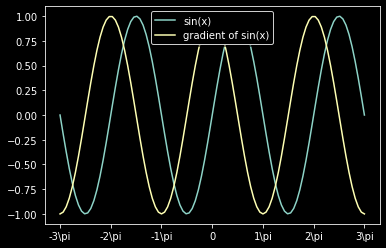

In [28]:
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
import torch

f,ax=plt.subplots(1)

x = np.linspace(-3*np.pi, 3*np.pi, 100)
x1= torch.tensor(x, requires_grad=True)
y1= torch.sin(x1)
y1.sum().backward()

ax.plot(x,np.sin(x),label='sin(x)')
ax.plot(x,x1.grad,label="gradient of sin(x)")
ax.legend(loc='upper center', shadow=True)

ax.xaxis.set_major_formatter(FuncFormatter(
lambda val,pos: '{:.0g}\pi'.format(val/np.pi) if val !=0 else '0'))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

plt.show()